In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from math import sqrt
from numpy import concatenate
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.dates as mdates
months = mdates.MonthLocator()


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data = pd.read_csv('/content/drive/MyDrive/all_breakdown.csv', usecols=['TIMESTAMP','SOLAR THERMAL', 'Hour'])

In [14]:
data = data.sort_values(by=['TIMESTAMP'])
df = data[data['SOLAR THERMAL'].notna()]
print(df.head())

                 TIMESTAMP  Hour  SOLAR THERMAL
35280  2012-11-26 00:00:00   1.0            0.0
35281  2012-11-26 01:00:00   2.0            0.0
35282  2012-11-26 02:00:00   3.0            0.0
35283  2012-11-26 03:00:00   4.0            0.0
35284  2012-11-26 04:00:00   5.0            0.0


In [15]:
full_data = df
full_data

,TIMESTAMP,Hour,SOLAR THERMAL
35280,2012-11-26 00:00:00,1.0,0.0
35281,2012-11-26 01:00:00,2.0,0.0
35282,2012-11-26 02:00:00,3.0,0.0
35283,2012-11-26 03:00:00,4.0,0.0
35284,2012-11-26 04:00:00,5.0,0.0
...,...,...,...
57115,2018-01-16 19:00:00,20.0,0.0
57116,2018-01-16 20:00:00,21.0,0.0
57117,2018-01-16 21:00:00,22.0,0.0
57118,2018-01-16 22:00:00,23.0,0.0


In [16]:
full_data['TIMESTAMP'] = pd.to_datetime(full_data['TIMESTAMP'])

full_data['MONTH'] = full_data['TIMESTAMP'].dt.month
full_data['YEAR'] = full_data['TIMESTAMP'].dt.year
full_data['DAY'] = full_data['TIMESTAMP'].dt.day
full_data['HOUR'] = full_data['TIMESTAMP'].dt.hour

full_data

,TIMESTAMP,Hour,SOLAR THERMAL,MONTH,YEAR,DAY,HOUR
35280,2012-11-26 00:00:00,1.0,0.0,11,2012,26,0
35281,2012-11-26 01:00:00,2.0,0.0,11,2012,26,1
35282,2012-11-26 02:00:00,3.0,0.0,11,2012,26,2
35283,2012-11-26 03:00:00,4.0,0.0,11,2012,26,3
35284,2012-11-26 04:00:00,5.0,0.0,11,2012,26,4
...,...,...,...,...,...,...,...
57115,2018-01-16 19:00:00,20.0,0.0,1,2018,16,19
57116,2018-01-16 20:00:00,21.0,0.0,1,2018,16,20
57117,2018-01-16 21:00:00,22.0,0.0,1,2018,16,21
57118,2018-01-16 22:00:00,23.0,0.0,1,2018,16,22


In [17]:
full_data[full_data['TIMESTAMP'] > '2012-11-26 00:00:00']

,TIMESTAMP,Hour,SOLAR THERMAL,MONTH,YEAR,DAY,HOUR
35281,2012-11-26 01:00:00,2.0,0.0,11,2012,26,1
35282,2012-11-26 02:00:00,3.0,0.0,11,2012,26,2
35283,2012-11-26 03:00:00,4.0,0.0,11,2012,26,3
35284,2012-11-26 04:00:00,5.0,0.0,11,2012,26,4
35285,2012-11-26 05:00:00,6.0,0.0,11,2012,26,5
...,...,...,...,...,...,...,...
57115,2018-01-16 19:00:00,20.0,0.0,1,2018,16,19
57116,2018-01-16 20:00:00,21.0,0.0,1,2018,16,20
57117,2018-01-16 21:00:00,22.0,0.0,1,2018,16,21
57118,2018-01-16 22:00:00,23.0,0.0,1,2018,16,22


In [18]:
full_data.isnull().sum()

TIMESTAMP        0
Hour             0
SOLAR THERMAL    0
MONTH            0
YEAR             0
DAY              0
HOUR             0
dtype: int64

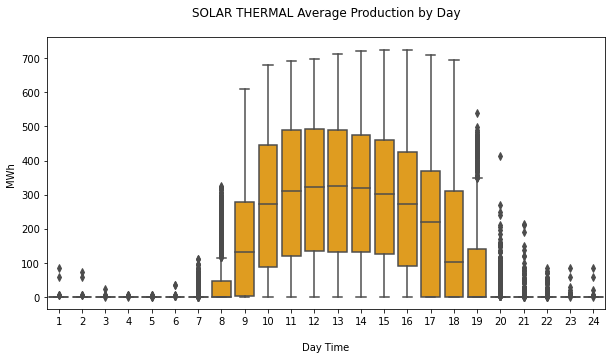

In [20]:
partial_data = pd.DataFrame(full_data.loc[full_data.TIMESTAMP > pd.to_datetime('2012-11-26 00:00:00'),['SOLAR THERMAL','Hour']])
partial_data.Hour = partial_data.Hour.map(lambda x : int(x))
for i in partial_data.columns[:-1]:
    plt.figure(figsize=(10,5))
    sns.boxplot(partial_data['Hour'],partial_data[i], color='orange')

    plt.title('{} Average Production by Day\n'.format(i))
    plt.xlabel('\nDay Time')

    plt.ylabel("MWh ")

plt.show()

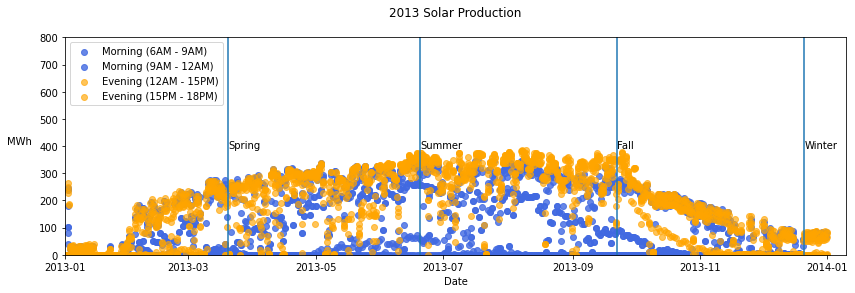

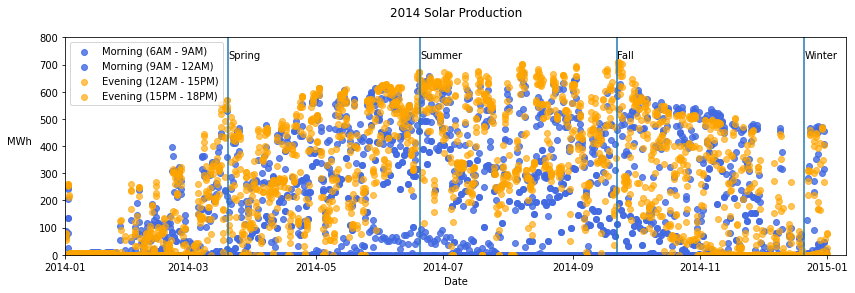

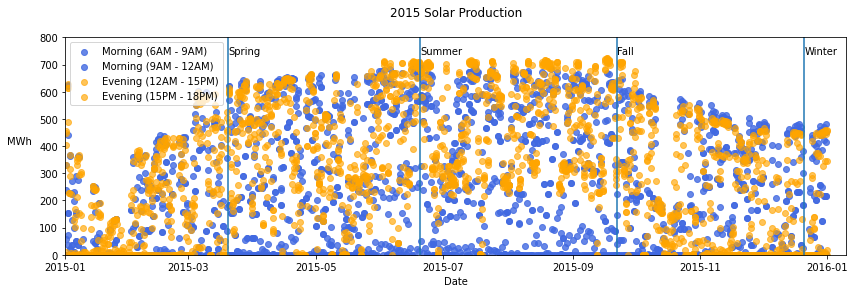

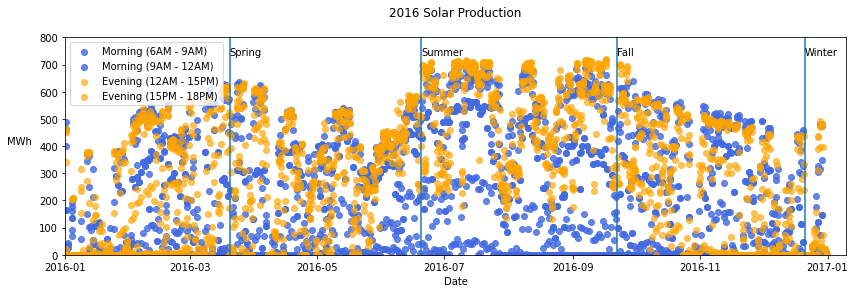

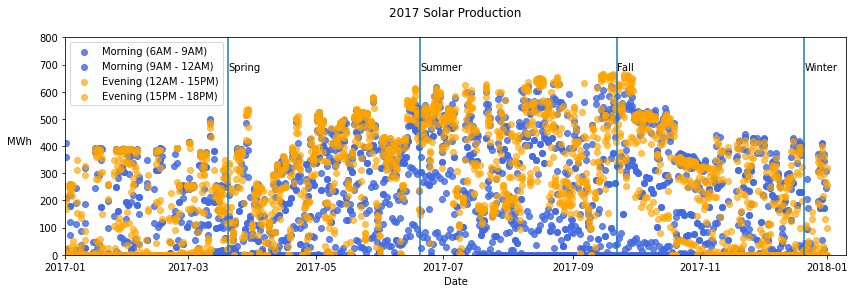

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

for year in range(2013,2018):
    data = full_data.loc[full_data['YEAR']==year,:]
    hour = data.loc[:,'Hour'].values   
    mask_early_morning = ((hour > 6)&(hour <= 9))
    mask_late_morning = ((hour >= 9)&(hour <= 12))   
    mask_early_afternoon = ((hour > 12)&(hour <=15))
    mask_late_afternoon = ((hour > 15)&(hour <=18))
    x = data['TIMESTAMP']
    y = data['SOLAR THERMAL']
    plt.figure(figsize=(14,4)) 
    plt.scatter(x[mask_early_morning], y[mask_early_morning],c='royalblue',alpha=.8,label='Morning (6AM - 9AM)')
    plt.scatter(x[mask_late_morning], y[mask_late_morning],c='royalblue',alpha=.8,label='Morning (9AM - 12AM)')  
    plt.scatter(x[mask_early_afternoon], y[mask_early_afternoon],c='orange',alpha=.65,label='Evening (12AM - 15PM)')
    plt.scatter(x[mask_late_afternoon], y[mask_late_afternoon],c='orange',alpha=.65,label='Evening (15PM - 18PM)')
    #plt.ylim(0,y.max()*1.15)
    plt.ylim(bottom=0,top =800)
    plt.xlim(pd.to_datetime('01/01/{}'.format(year)),pd.to_datetime('01/10/{}'.format(year+1)))
    plt.ylabel('MWh ',rotation='0',ha='right')
    plt.xlabel('Date')
    plt.title('{} Solar Production\n'.format(year))
    plt.legend(loc='upper left')
    seasons = [(pd.to_datetime('June 20, {}'.format(year)), 'Summer'),
           (pd.to_datetime('December 21, {}'.format(year)), 'Winter'),
           (pd.to_datetime('September 22, {}'.format(year)), 'Fall'),
           (pd.to_datetime('March 20, {}'.format(year)), 'Spring')]
    for date,season in seasons:
        plt.axvline(date)
        plt.text(date,y.max()*1.02,season)
    plt.show() 

## Using Prophet

In [ ]:
model_data = pd.DataFrame(full_data.loc[full_data.TIMESTAMP.dt.year > 2013,['TIMESTAMP', 'SOLAR THERMAL']])

model_data.columns = ['ds','y']
model_data.sort_values('ds', inplace=True)

display(model_data.head())

train = model_data.loc[model_data.ds.dt.year < 2017,:]
test = model_data.loc[model_data.ds.dt.year == 2017, :] 

,ds,y
17040,2014-01-01 00:00:00,0.0
17041,2014-01-01 01:00:00,0.0
17042,2014-01-01 02:00:00,0.0
17043,2014-01-01 03:00:00,0.0
17044,2014-01-01 04:00:00,0.0


In [ ]:
def on_season(ds):
    date = pd.to_datetime(ds)
    return ((date.month >= 3) & (date.month <= 9))

model_data['on_season'] = model_data['ds'].apply(on_season)
model_data['off_season'] = ~model_data['ds'].apply(on_season)
model_data['cap'] = 1500



model_data.y = np.cbrt(model_data.y)
model_data.cap = np.cbrt(model_data.cap)
display(model_data.head())


train = model_data.loc[model_data.ds.dt.year < 2017,:]
test = model_data.loc[model_data.ds.dt.year == 2017, :] 

,ds,y,on_season,off_season,cap
17040,2014-01-01 00:00:00,0.0,False,True,11.447142
17041,2014-01-01 01:00:00,0.0,False,True,11.447142
17042,2014-01-01 02:00:00,0.0,False,True,11.447142
17043,2014-01-01 03:00:00,0.0,False,True,11.447142
17044,2014-01-01 04:00:00,0.0,False,True,11.447142


In [ ]:
model = Prophet(changepoint_range=.8,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=150,
               growth='logistic',changepoint_prior_scale=.01,seasonality_prior_scale=20)

model.add_seasonality(name='on_season_daily', period=1, condition_name='on_season', fourier_order=6)
model.add_seasonality(name='off_season_daily', period=1, condition_name='off_season', fourier_order=6)

model.fit(train)

In [ ]:
future = model.make_future_dataframe(periods=1460*24, freq='H')

future['on_season'] = future['ds'].apply(on_season)
future['off_season'] = ~future['ds'].apply(on_season)
future['cap'] = 2000
future.cap = np.cbrt(future.cap)

forecast = model.predict(future)

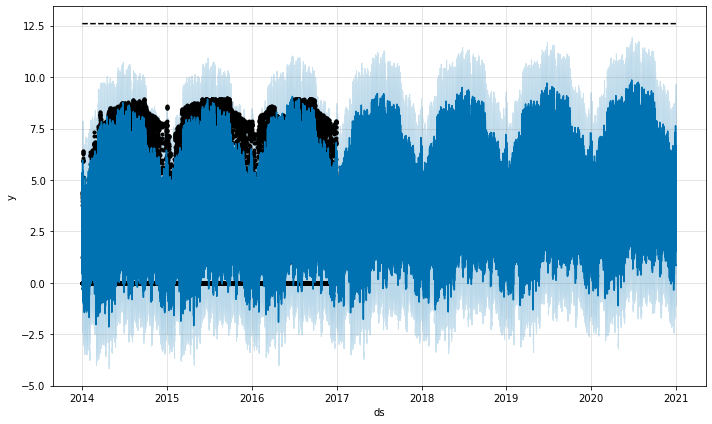

In [ ]:
fig = model.plot(forecast)

plt.show() 

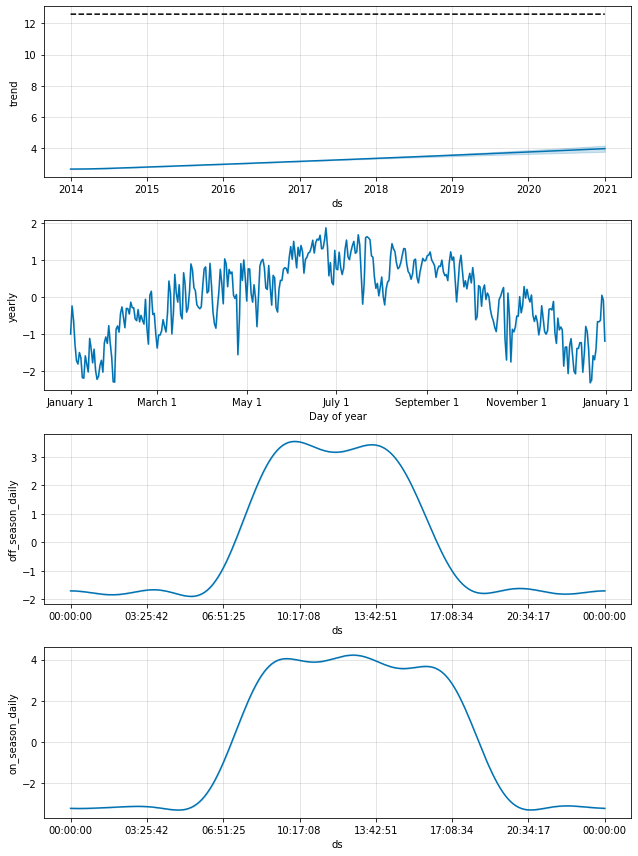

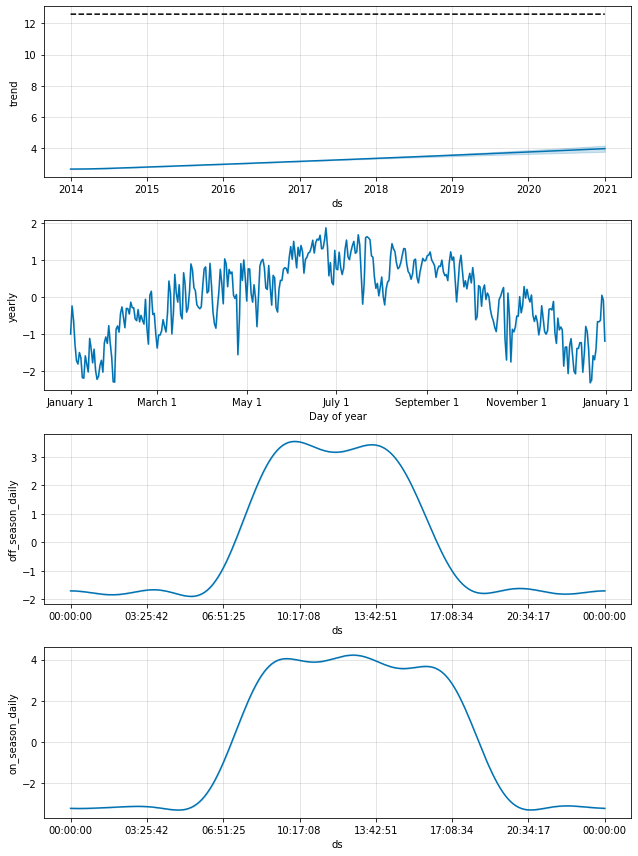

In [ ]:
model.plot_components(forecast) 

We can now recreate the previous chart to see how the predictions have changed:

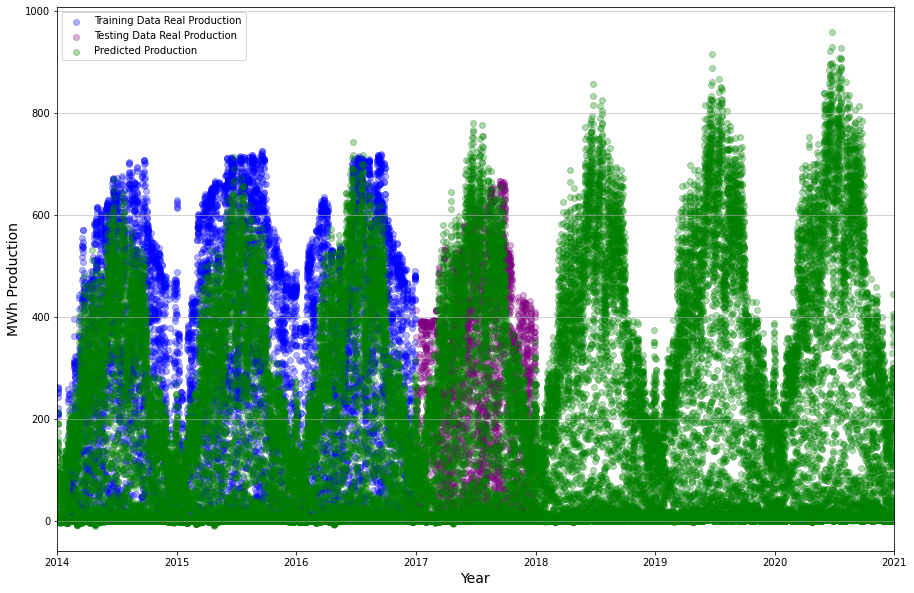

In [ ]:
train.y = train.y**3
test.y = test.y**3
forecast.yhat = forecast.yhat**3

# look at it in a differnt way 
plt.figure(figsize=(15,10))

plt.scatter(train['ds'],train['y'], color='b',alpha=.3,label='Training Data Real Production')
plt.scatter(test['ds'],test['y'],color='purple',alpha=.3,label='Testing Data Real Production')
plt.scatter(forecast['ds'],forecast['yhat'],color='green',alpha=.3,label='Predicted Production')

plt.xlim(pd.to_datetime('2014-01-01'),pd.to_datetime('2021-01-01'))
plt.ylabel('MWh Production', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend()
plt.grid(axis='y',alpha=.7)
#plt.ylim(bottom=0,top =300000)

plt.show() 

It seems like the model is fitting the solar production data pretty well now! To quantify the model fit:

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

forecastTrain = forecast.loc[forecast.ds.dt.year < 2017,:]
forecastTest = forecast.loc[forecast.ds.dt.year == 2017,:]

forecastTest.set_index(pd.DatetimeIndex(forecastTest.ds), inplace=True)
test = test.loc[test.ds.dt.year == 2017,:]
test.set_index(pd.DatetimeIndex(test.ds), inplace=True)

testDf = forecastTest.merge(test, how='outer', right_index=True, left_index=True)
testDf.y = testDf.y.fillna(0)
testDf.yhat = testDf.yhat.fillna(0)

print("Train R2 Score: ", r2_score(train.y, forecastTrain.yhat))
print("Train MAE: ", mean_absolute_error(train.y, forecastTrain.yhat))

print("Test R2 Score: ", r2_score(testDf.y, testDf.yhat))
print("Test MAE: ", mean_absolute_error(testDf.y, testDf.yhat))

Train R2 Score:  0.7191823193327446
Train MAE:  60.62950348208085
Test R2 Score:  0.5722903956780829
Test MAE:  65.9141680695688


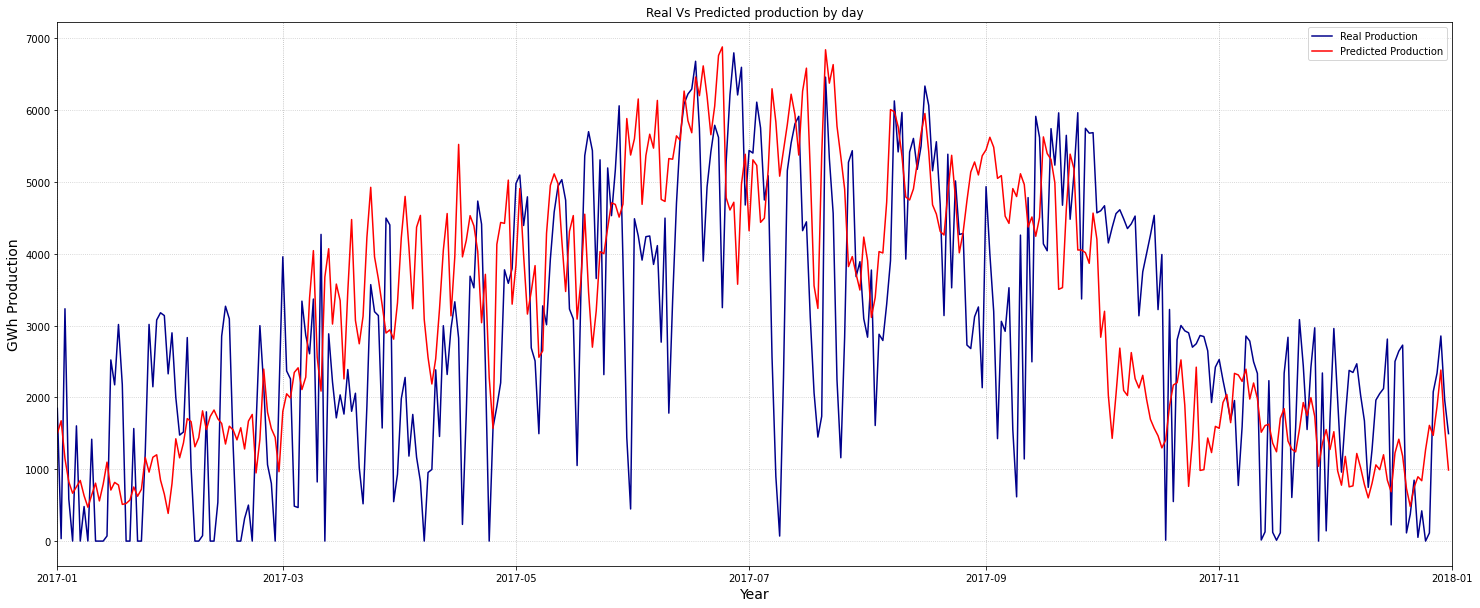

Predicted total 2017 Solar : 1167.22 GWh
True total 2017 Solar :  1063.57 GWh
Total Year % Error :  9.75 %


In [ ]:
plot = testDf[['y','yhat']]

plot = plot.resample('24H').sum()

plt.figure(figsize=(25,10))
plt.plot(plot.index, plot.y, label="Real Production", color='darkblue')
plt.plot(plot.index, plot.yhat, label="Predicted Production", color='r')
plt.legend()
plt.title("Real Vs Predicted production by day")
plt.grid(linestyle=":")
plt.xlim(pd.to_datetime('2017-01-01'),pd.to_datetime('2018-01-01'))

plt.ylabel('GWh Production', fontsize =14)
plt.xlabel('Year', fontsize = 14)
plt.legend()
plt.grid(axis='y',alpha=.7)
plt.show()

print("Predicted total 2017 Solar :", round(plot.yhat.sum() / 1000,2), "GWh")
print("True total 2017 Solar : ", round(plot.y.sum() / 1000,2), "GWh")
print("Total Year % Error : ", round(((np.abs(plot.yhat.sum() - plot.y.sum()))/ plot.y.sum()) * 100,2), "%")